In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout, add, LayerNormalization, MultiHeadAttention
from tensorflow.keras import layers

In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [3]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature


pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1754210251.737091      94 service.cc:145] XLA service 0x7e4ae8005b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754210251.737144      94 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754210253.545774      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [5]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [6]:
mapping = {}

captions = captions_doc.split('\n')
half_length = len(captions) // 2 

for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    
    if len(line) < 2:
        continue
        
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [7]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

clean(mapping)

In [8]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1


max_length = max(len(caption.split()) for caption in all_captions)

In [9]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [10]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    
    while True:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen = max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
                    
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0

<h1>Model</h1>

In [11]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Dense, Embedding, Input, Lambda, add
from tensorflow.keras.models import Model


inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)


input_attn_output = se1
for _ in range(1):  
    input_attn_output = MultiHeadAttention(num_heads=8, key_dim=256)(input_attn_output, input_attn_output)
    input_attn_output = LayerNormalization(epsilon=1e-6)(input_attn_output + se1)
    fwd_output = Dense(512, activation='relu')(input_attn_output)
    fwd_output = Dense(256)(fwd_output)
    input_attn_output = LayerNormalization(epsilon=1e-6)(fwd_output + input_attn_output)


attn_output = add([fe2, input_attn_output])


decoder_attn_output = attn_output
for _ in range(1): 
    decoder_attn_output = MultiHeadAttention(num_heads=8, key_dim=256)(decoder_attn_output, decoder_attn_output)
    decoder_attn_output = LayerNormalization(epsilon=1e-6)(decoder_attn_output + attn_output)
    fwd_output = Dense(512, activation='relu')(decoder_attn_output)
    fwd_output = Dense(256)(fwd_output)
    decoder_attn_output = LayerNormalization(epsilon=1e-6)(fwd_output + decoder_attn_output)


decoder1 = add([fe2, decoder_attn_output])
decoder2 = Dense(256, activation='relu')(decoder1)

last_timestep_output = Lambda(lambda x: x[:, -1, :])(decoder2)
outputs = Dense(vocab_size, activation='softmax')(last_timestep_output)


model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 35, 256)   │  2,172,160 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 35)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 35, 256)   │  2,103,552 │ embedding[0][0],  │
│ (MultiHeadAttentio… │                   │            │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 35, 256)   │          0 │ multi_head_atten… │
│                     │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 35, 256)   │        512 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 35, 512)   │    131,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 35, 256)   │    131,328 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 35, 256)   │          0 │ dense_2[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 35, 256)   │        512 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 35, 256)   │          0 │ dense[0][0],      │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 35, 256)   │  2,103,552 │ add_2[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 35, 256)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 35, 256)   │        512 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 10,202,405 (38.92 MB)

 Trainable params: 10,202,405 (38.92 MB)

 Non-trainable params: 0 (0.00 B)

None


In [13]:
epochs = 40
batch_size = 10
steps_per_epoch = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs = 1, steps_per_epoch = steps_per_epoch, verbose = 1)

model.save(os.path.join(WORKING_DIR, 'model.h5'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


728/728 ━━━━━━━━━━━━━━━━━━━━ 934s 1s/step - loss: 5.7066
728/728 ━━━━━━━━━━━━━━━━━━━━ 88s 120ms/step - loss: 4.6499
728/728 ━━━━━━━━━━━━━━━━━━━━ 88s 120ms/step - loss: 4.3799
728/728 ━━━━━━━━━━━━━━━━━━━━ 88s 121ms/step - loss: 4.1920
728/728 ━━━━━━━━━━━━━━━━━━━━ 88s 121ms/step - loss: 3.9916
728/728 ━━━━━━━━━━━━━━━━━━━━ 88s 121ms/step - loss: 3.8639
728/728 ━━━━━━━━━━━━━━━━━━━━ 88s 121ms/step - loss: 3.7409
728/728 ━━━━━━━━━━━━━━━━━━━━ 88s 121ms/step - loss: 3.6891
728/728 ━━━━━━━━━━━━━━━━━━━━ 88s 120ms/step - loss: 3.6787
728/728 ━━━━━━━━━━━━━━━━━━━━ 88s 121ms/step - loss: 3.6568
728/728 ━━━━━━━━━━━━━━━━━━━━ 88s 120ms/step - loss: 3.6522
728/728 ━━━━━━━━━━━━━━━━━━━━ 88s 120ms/step - loss: 3.5765
728/728 ━━━━━━━━━━━━━━━━━━━━ 88s 121ms/step - loss: 3.5873
728/728 ━━━━━━━━━━━━━━━━━━━━ 88s 120ms/step - loss: 3.5335
728/728 ━━━━━━━━━━━━━━━━━━━━ 88s 121ms/step - loss: 3.4681
728/728 ━━━━━━━━━━━━━━━━━━━━ 88s 121ms/step - loss: 3.4197
728/728 ━━━━━━━━━━━━━━━━━━━━ 88s 120ms/step - loss: 3.4075

In [14]:
epochs = 5
batch_size = 30
steps_per_epoch = len(train) // batch_size


for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs = 1, steps_per_epoch = steps_per_epoch, verbose = 1)


model.save(os.path.join(WORKING_DIR, 'model.h5'))

242/242 ━━━━━━━━━━━━━━━━━━━━ 1300s 5s/step - loss: 3.2597
242/242 ━━━━━━━━━━━━━━━━━━━━ 83s 344ms/step - loss: 3.2252
242/242 ━━━━━━━━━━━━━━━━━━━━ 83s 342ms/step - loss: 3.1980
242/242 ━━━━━━━━━━━━━━━━━━━━ 83s 342ms/step - loss: 3.1735
242/242 ━━━━━━━━━━━━━━━━━━━━ 83s 342ms/step - loss: 3.1625


In [15]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences


def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    
    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat, axis=-1)
        word = idx_to_word(yhat, tokenizer)
        
        if word is None:
            break
        
       
        in_text += " " + word
        if word == 'endseq':
            break
            
   
    return in_text.replace('startseq', '').replace('endseq', '').strip()

In [16]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name, model, tokenizer, features, mapping, max_length, BASE_DIR):
    image_id = image_name.split('.')[0]  
    img_path = os.path.join(BASE_DIR, "Images", image_name)  
    image = Image.open(img_path) 
    
   
    captions = mapping[image_id]  
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    
   
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)  
    print('--------------------Predicted--------------------')
    print(y_pred)  
    
    
    plt.imshow(image)
    plt.axis('off')  
    plt.show()  

In [17]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

---------------------Actual---------------------
startseq man lays on bench while his dog sits by him endseq
startseq man lays on the bench to which white dog is also tied endseq
startseq man sleeping on bench outside with white and black dog sitting next to him endseq
startseq shirtless man lies on park bench with his dog endseq
startseq man laying on bench holding leash of dog sitting on ground endseq
--------------------Predicted--------------------
man lies on bench


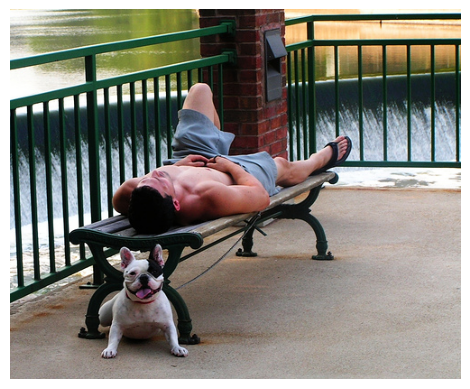

In [18]:
image_name = "1003163366_44323f5815.jpg"  
generate_caption(image_name, model, tokenizer, features, mapping, max_length, BASE_DIR)

In [19]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)


print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.142241
BLEU-2: 0.075229
